# Actor-Critic

This Notebook reimplements PyTorch's actor-critic example for Cartpole for Pong. The code runs into GPU memory error.



In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
import platform
import gym
import random
import torch
import pickle as pickle
import pympler
import gc

# For advanced computer vision
import cv2

# For memory tracking
from pympler import summary
from pympler import muppy

cpu_dtype = torch.FloatTensor
gpu_dtype = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


In [2]:
import gc
gc.collect()

11

## Implement PyTorch REINFORCE-Pong (Version 2)

We will now reimplement the REINFORCE-Pong in PyTorch:

* Run time episode is 0.7sec with GPU acceleration.  

We first tried to downsample the Pong image (80x80 to 40x40) and the number of iteration run increases from 75 to 1000+. But we still encounter GPU out of memory error.

Next we limit the number of steps per episode to 800 (instead of allowing the game to play to end of episodes). There is no more GPU out of memory error, but the training curve flattens 

In [17]:
import argparse
import gym
import numpy as np
from itertools import count

# For memory tracking
from pympler import summary
from pympler import muppy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical
import gc

gamma=0.99
seed=543
render=False
log_interval=10
batch_size = 800
verbose=False  # To step through the code and understand what is going on

reinforce=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# The function approximator of the Policy is a 2 layer NN. 
# - The policy takes in the state of Pong, which is a resampled 40x40 image
# - The action is the softmax output (Left or Right)
# - there are 200 hidden units in the NN
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.affine2 = nn.Linear(200, 2)  
        
        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Call an instance of the Policy and select ADAM as update rule
policy = Policy().cuda()
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::4,::4,0] # downsample by factor of 4
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """
    
    state = torch.from_numpy(state).float().unsqueeze(0)
    if verbose:
        print ("Pong's state output:", state.shape, state)
    
    # Use Policy to generate probability for action
    probs = policy(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    if verbose:
        print ("Pong Action:", action.data[0]+2)
        print ("log_prob(action):", m.log_prob(action))
        
    # Store log_prob (score function) into a list for calculating policy gradient    
    policy.saved_log_probs.append(m.log_prob(action))
    
    del state, probs, m
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch():
    """ 
    Based on REINFORCE, policy gradient is computed at the end of a batch (instead of an
    episode). It is then used to update the Policy's weights
    """

    R = 0
    policy_loss = []
    rewards = []   # This is v_t
    
    if verbose:
        print ("Rewards:", policy.rewards)
    
    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)
    if verbose:
        print ("v_t:", rewards)   

    # Calculate policy gradient ∇_θ log (π_θ ( s_t , a_t ) )v_t
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * reward)   # negative because gradient descent

    if verbose:
        print ("Policy Gradient:", policy_loss)  
        
    optimizer.zero_grad()  # zero the gradients before running the optimizer
    
    # Sum policy gradients for all time steps in the episode
    policy_loss = torch.cat(policy_loss).sum()   
    if verbose:
        print ("Policy loss (after cat and sum):", policy_loss)  
        
    # The TRICK: backward() on policy_loss instead of policy
    # Policy's parameters are updated here.
    policy_loss.backward()  
    optimizer.step()
    
    del rewards, policy_loss  # start deleting stuffs to address memory leak
    del policy.rewards[:]
    del policy.saved_log_probs[:]


# Main loop
prev_x = None
running_reward = -15

start = time.time()
# for i_episode in count(1):  # Infinite loop
for i_episode in range(30000): # just run 30000 episode    
    state = env.reset()
    reward_sum = 0
    
    for t in range(10000):  # Don't infinite loop while learning
        
        # Downsample 210x160x3 frame into 1600 (80x80) 1D float vector
        cur_x = prepro(state)
        state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
        prev_x = cur_x
        
        # Sample an action from Policy based on state provided by env
        action = select_action(state)
        
        # step env through the sampled action
        state, reward, done, _ = env.step(action)  # UP=2, DOWN=3
        reward_sum += reward
        
        if render:
            env.render()
            
        # append reward to policy.reward[]
        # this is needed to calculate policy gradient at the end of the episode  
        policy.rewards.append(reward)
        
        if done or t > batch_size:
            break
        

    # Calculate policy gradient and update Policy 
    finish_batch()
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    
    running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
   
    reinforce.append([reward_sum, running_reward])
    # print out and show sign of life
    if i_episode % log_interval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                i_episode, reward_sum, running_reward))
    
    # track memory usage every 100 episodes
    if i_episode % 2000 == 0:
         summary.print_(summary.summarize(muppy.get_objects()))
         file_name = './results/reinforce/pong_'+'ep='+str(i_episode)+'model.pt'
         torch.save(policy.state_dict(), file_name)


end = time.time()
print ("Time taken:", start-end)

Episode 0	Last Reward: -14.00	Running Reward: -14.99
                                         types |   # objects |   total size
============================================== | =========== | ============
                                   <class 'str |       88581 |     11.92 MB
                                  <class 'dict |       15012 |      6.00 MB
                                  <class 'type |        2897 |      2.97 MB
                                  <class 'code |       20518 |      2.83 MB
                                  <class 'list |       21230 |      2.18 MB
                                   <class 'set |        2135 |    900.03 KB
                                 <class 'tuple |       11019 |    733.38 KB
                     <class 'method_descriptor |        7050 |    495.70 KB
                               <class 'weakref |        5474 |    427.66 KB
                                   <class 'int |        9673 |    285.75 KB
  <class 'torch.autograd.function.F

Episode 1280	Last Reward: -12.00	Running Reward: -8.30
Episode 1290	Last Reward: -5.00	Running Reward: -8.17
Episode 1300	Last Reward: -5.00	Running Reward: -8.14
Episode 1310	Last Reward: -7.00	Running Reward: -8.03
Episode 1320	Last Reward: -7.00	Running Reward: -7.99
Episode 1330	Last Reward: -11.00	Running Reward: -8.00
Episode 1340	Last Reward: -7.00	Running Reward: -7.92
Episode 1350	Last Reward: -4.00	Running Reward: -7.84
Episode 1360	Last Reward: -7.00	Running Reward: -7.89
Episode 1370	Last Reward: -9.00	Running Reward: -7.81
Episode 1380	Last Reward: -7.00	Running Reward: -7.68
Episode 1390	Last Reward: -10.00	Running Reward: -7.76
Episode 1400	Last Reward: -7.00	Running Reward: -7.69
Episode 1410	Last Reward: -7.00	Running Reward: -7.66
Episode 1420	Last Reward: -9.00	Running Reward: -7.66
Episode 1430	Last Reward: -9.00	Running Reward: -7.61
Episode 1440	Last Reward: -7.00	Running Reward: -7.51
Episode 1450	Last Reward: -11.00	Running Reward: -7.54
Episode 1460	Last Reward

Episode 2560	Last Reward: 0.00	Running Reward: -3.25
Episode 2570	Last Reward: -5.00	Running Reward: -3.28
Episode 2580	Last Reward: -1.00	Running Reward: -3.26
Episode 2590	Last Reward: -6.00	Running Reward: -3.32
Episode 2600	Last Reward: -2.00	Running Reward: -3.34
Episode 2610	Last Reward: -4.00	Running Reward: -3.31
Episode 2620	Last Reward: -3.00	Running Reward: -3.29
Episode 2630	Last Reward: -2.00	Running Reward: -3.30
Episode 2640	Last Reward: -5.00	Running Reward: -3.33
Episode 2650	Last Reward: -5.00	Running Reward: -3.30
Episode 2660	Last Reward: -5.00	Running Reward: -3.31
Episode 2670	Last Reward: -4.00	Running Reward: -3.31
Episode 2680	Last Reward: -3.00	Running Reward: -3.28
Episode 2690	Last Reward: -6.00	Running Reward: -3.31
Episode 2700	Last Reward: -2.00	Running Reward: -3.33
Episode 2710	Last Reward: -3.00	Running Reward: -3.37
Episode 2720	Last Reward: -9.00	Running Reward: -3.46
Episode 2730	Last Reward: -9.00	Running Reward: -3.50
Episode 2740	Last Reward: -6.

Episode 4010	Last Reward: -1.00	Running Reward: -2.08
Episode 4020	Last Reward: -3.00	Running Reward: -2.16
Episode 4030	Last Reward: 0.00	Running Reward: -2.13
Episode 4040	Last Reward: -4.00	Running Reward: -2.07
Episode 4050	Last Reward: 0.00	Running Reward: -2.04
Episode 4060	Last Reward: -5.00	Running Reward: -2.06
Episode 4070	Last Reward: -3.00	Running Reward: -2.00
Episode 4080	Last Reward: -2.00	Running Reward: -1.89
Episode 4090	Last Reward: 1.00	Running Reward: -1.81
Episode 4100	Last Reward: 2.00	Running Reward: -1.89
Episode 4110	Last Reward: 3.00	Running Reward: -1.79
Episode 4120	Last Reward: -6.00	Running Reward: -1.87
Episode 4130	Last Reward: -1.00	Running Reward: -1.93
Episode 4140	Last Reward: -4.00	Running Reward: -1.94
Episode 4150	Last Reward: -5.00	Running Reward: -2.02
Episode 4160	Last Reward: 0.00	Running Reward: -1.93
Episode 4170	Last Reward: -4.00	Running Reward: -1.94
Episode 4180	Last Reward: 2.00	Running Reward: -1.95
Episode 4190	Last Reward: -1.00	Run

Episode 5540	Last Reward: -1.00	Running Reward: -1.46
Episode 5550	Last Reward: -2.00	Running Reward: -1.39
Episode 5560	Last Reward: -4.00	Running Reward: -1.46
Episode 5570	Last Reward: -1.00	Running Reward: -1.51
Episode 5580	Last Reward: -4.00	Running Reward: -1.50
Episode 5590	Last Reward: -3.00	Running Reward: -1.56
Episode 5600	Last Reward: -3.00	Running Reward: -1.60
Episode 5610	Last Reward: 0.00	Running Reward: -1.66
Episode 5620	Last Reward: -1.00	Running Reward: -1.74
Episode 5630	Last Reward: 0.00	Running Reward: -1.72
Episode 5640	Last Reward: -1.00	Running Reward: -1.76
Episode 5650	Last Reward: -1.00	Running Reward: -1.65
Episode 5660	Last Reward: 2.00	Running Reward: -1.62
Episode 5670	Last Reward: 0.00	Running Reward: -1.59
Episode 5680	Last Reward: -5.00	Running Reward: -1.66
Episode 5690	Last Reward: -3.00	Running Reward: -1.57
Episode 5700	Last Reward: -5.00	Running Reward: -1.70
Episode 5710	Last Reward: -2.00	Running Reward: -1.68
Episode 5720	Last Reward: -2.00	

Episode 6830	Last Reward: 1.00	Running Reward: -1.23
Episode 6840	Last Reward: 0.00	Running Reward: -1.13
Episode 6850	Last Reward: -2.00	Running Reward: -1.13
Episode 6860	Last Reward: -2.00	Running Reward: -1.08
Episode 6870	Last Reward: -2.00	Running Reward: -1.05
Episode 6880	Last Reward: 0.00	Running Reward: -1.14
Episode 6890	Last Reward: -1.00	Running Reward: -1.14
Episode 6900	Last Reward: 2.00	Running Reward: -1.19
Episode 6910	Last Reward: -2.00	Running Reward: -1.10
Episode 6920	Last Reward: -3.00	Running Reward: -1.05
Episode 6930	Last Reward: -2.00	Running Reward: -1.13
Episode 6940	Last Reward: -4.00	Running Reward: -1.15
Episode 6950	Last Reward: 2.00	Running Reward: -1.09
Episode 6960	Last Reward: -3.00	Running Reward: -1.05
Episode 6970	Last Reward: -4.00	Running Reward: -1.17
Episode 6980	Last Reward: 0.00	Running Reward: -1.27
Episode 6990	Last Reward: -1.00	Running Reward: -1.26
Episode 7000	Last Reward: -4.00	Running Reward: -1.35
Episode 7010	Last Reward: -1.00	Ru

Episode 8120	Last Reward: 0.00	Running Reward: -1.24
Episode 8130	Last Reward: -4.00	Running Reward: -1.34
Episode 8140	Last Reward: 0.00	Running Reward: -1.27
Episode 8150	Last Reward: -3.00	Running Reward: -1.26
Episode 8160	Last Reward: -3.00	Running Reward: -1.31
Episode 8170	Last Reward: 0.00	Running Reward: -1.35
Episode 8180	Last Reward: -5.00	Running Reward: -1.42
Episode 8190	Last Reward: -5.00	Running Reward: -1.49
Episode 8200	Last Reward: -2.00	Running Reward: -1.49
Episode 8210	Last Reward: -1.00	Running Reward: -1.52
Episode 8220	Last Reward: 0.00	Running Reward: -1.46
Episode 8230	Last Reward: 0.00	Running Reward: -1.56
Episode 8240	Last Reward: -3.00	Running Reward: -1.55
Episode 8250	Last Reward: -2.00	Running Reward: -1.54
Episode 8260	Last Reward: 1.00	Running Reward: -1.44
Episode 8270	Last Reward: -3.00	Running Reward: -1.44
Episode 8280	Last Reward: -3.00	Running Reward: -1.50
Episode 8290	Last Reward: 0.00	Running Reward: -1.44
Episode 8300	Last Reward: 0.00	Runn

Episode 9650	Last Reward: -3.00	Running Reward: -1.18
Episode 9660	Last Reward: 1.00	Running Reward: -1.15
Episode 9670	Last Reward: -1.00	Running Reward: -1.19
Episode 9680	Last Reward: -3.00	Running Reward: -1.21
Episode 9690	Last Reward: -4.00	Running Reward: -1.30
Episode 9700	Last Reward: 2.00	Running Reward: -1.28
Episode 9710	Last Reward: 0.00	Running Reward: -1.29
Episode 9720	Last Reward: 2.00	Running Reward: -1.29
Episode 9730	Last Reward: -2.00	Running Reward: -1.33
Episode 9740	Last Reward: -3.00	Running Reward: -1.40
Episode 9750	Last Reward: 1.00	Running Reward: -1.39
Episode 9760	Last Reward: 3.00	Running Reward: -1.32
Episode 9770	Last Reward: -2.00	Running Reward: -1.29
Episode 9780	Last Reward: -1.00	Running Reward: -1.18
Episode 9790	Last Reward: 0.00	Running Reward: -1.14
Episode 9800	Last Reward: 1.00	Running Reward: -1.09
Episode 9810	Last Reward: -2.00	Running Reward: -1.19
Episode 9820	Last Reward: 0.00	Running Reward: -1.22
Episode 9830	Last Reward: -1.00	Runni

Episode 10920	Last Reward: -3.00	Running Reward: -1.38
Episode 10930	Last Reward: -6.00	Running Reward: -1.47
Episode 10940	Last Reward: -4.00	Running Reward: -1.51
Episode 10950	Last Reward: -4.00	Running Reward: -1.48
Episode 10960	Last Reward: -3.00	Running Reward: -1.45
Episode 10970	Last Reward: -4.00	Running Reward: -1.40
Episode 10980	Last Reward: -3.00	Running Reward: -1.45
Episode 10990	Last Reward: -2.00	Running Reward: -1.43
Episode 11000	Last Reward: -2.00	Running Reward: -1.48
Episode 11010	Last Reward: 0.00	Running Reward: -1.45
Episode 11020	Last Reward: 0.00	Running Reward: -1.45
Episode 11030	Last Reward: -3.00	Running Reward: -1.49
Episode 11040	Last Reward: -1.00	Running Reward: -1.50
Episode 11050	Last Reward: -1.00	Running Reward: -1.55
Episode 11060	Last Reward: -2.00	Running Reward: -1.65
Episode 11070	Last Reward: 3.00	Running Reward: -1.62
Episode 11080	Last Reward: -3.00	Running Reward: -1.54
Episode 11090	Last Reward: -4.00	Running Reward: -1.69
Episode 11100

Episode 12190	Last Reward: -2.00	Running Reward: -1.79
Episode 12200	Last Reward: -2.00	Running Reward: -1.76
Episode 12210	Last Reward: -5.00	Running Reward: -1.81
Episode 12220	Last Reward: -5.00	Running Reward: -1.70
Episode 12230	Last Reward: -2.00	Running Reward: -1.62
Episode 12240	Last Reward: 3.00	Running Reward: -1.62
Episode 12250	Last Reward: 1.00	Running Reward: -1.63
Episode 12260	Last Reward: 0.00	Running Reward: -1.58
Episode 12270	Last Reward: -2.00	Running Reward: -1.64
Episode 12280	Last Reward: -2.00	Running Reward: -1.57
Episode 12290	Last Reward: -5.00	Running Reward: -1.68
Episode 12300	Last Reward: -1.00	Running Reward: -1.77
Episode 12310	Last Reward: -4.00	Running Reward: -1.67
Episode 12320	Last Reward: -3.00	Running Reward: -1.68
Episode 12330	Last Reward: -1.00	Running Reward: -1.63
Episode 12340	Last Reward: -3.00	Running Reward: -1.57
Episode 12350	Last Reward: -1.00	Running Reward: -1.51
Episode 12360	Last Reward: -1.00	Running Reward: -1.51
Episode 12370

Episode 13690	Last Reward: -3.00	Running Reward: -1.24
Episode 13700	Last Reward: -2.00	Running Reward: -1.38
Episode 13710	Last Reward: -2.00	Running Reward: -1.46
Episode 13720	Last Reward: -2.00	Running Reward: -1.36
Episode 13730	Last Reward: 0.00	Running Reward: -1.22
Episode 13740	Last Reward: -7.00	Running Reward: -1.35
Episode 13750	Last Reward: -3.00	Running Reward: -1.43
Episode 13760	Last Reward: -1.00	Running Reward: -1.47
Episode 13770	Last Reward: 0.00	Running Reward: -1.49
Episode 13780	Last Reward: -3.00	Running Reward: -1.49
Episode 13790	Last Reward: -1.00	Running Reward: -1.39
Episode 13800	Last Reward: 0.00	Running Reward: -1.37
Episode 13810	Last Reward: -2.00	Running Reward: -1.43
Episode 13820	Last Reward: 1.00	Running Reward: -1.45
Episode 13830	Last Reward: -1.00	Running Reward: -1.46
Episode 13840	Last Reward: -4.00	Running Reward: -1.49
Episode 13850	Last Reward: 1.00	Running Reward: -1.47
Episode 13860	Last Reward: 0.00	Running Reward: -1.46
Episode 13870	La

Episode 14960	Last Reward: 2.00	Running Reward: -0.92
Episode 14970	Last Reward: 0.00	Running Reward: -0.86
Episode 14980	Last Reward: -3.00	Running Reward: -0.87
Episode 14990	Last Reward: -2.00	Running Reward: -0.83
Episode 15000	Last Reward: -3.00	Running Reward: -0.94
Episode 15010	Last Reward: -2.00	Running Reward: -0.98
Episode 15020	Last Reward: -3.00	Running Reward: -1.13
Episode 15030	Last Reward: -2.00	Running Reward: -1.12
Episode 15040	Last Reward: -1.00	Running Reward: -1.11
Episode 15050	Last Reward: -2.00	Running Reward: -1.20
Episode 15060	Last Reward: 0.00	Running Reward: -1.04
Episode 15070	Last Reward: -2.00	Running Reward: -1.01
Episode 15080	Last Reward: -1.00	Running Reward: -0.99
Episode 15090	Last Reward: -3.00	Running Reward: -1.06
Episode 15100	Last Reward: -4.00	Running Reward: -1.02
Episode 15110	Last Reward: 0.00	Running Reward: -1.02
Episode 15120	Last Reward: 0.00	Running Reward: -1.09
Episode 15130	Last Reward: -1.00	Running Reward: -1.07
Episode 15140	L

Episode 16230	Last Reward: -1.00	Running Reward: -1.33
Episode 16240	Last Reward: -2.00	Running Reward: -1.30
Episode 16250	Last Reward: -4.00	Running Reward: -1.37
Episode 16260	Last Reward: 1.00	Running Reward: -1.27
Episode 16270	Last Reward: 0.00	Running Reward: -1.23
Episode 16280	Last Reward: 0.00	Running Reward: -1.21
Episode 16290	Last Reward: -3.00	Running Reward: -1.32
Episode 16300	Last Reward: 2.00	Running Reward: -1.30
Episode 16310	Last Reward: -2.00	Running Reward: -1.23
Episode 16320	Last Reward: 1.00	Running Reward: -1.14
Episode 16330	Last Reward: -1.00	Running Reward: -1.09
Episode 16340	Last Reward: -1.00	Running Reward: -1.13
Episode 16350	Last Reward: 0.00	Running Reward: -1.04
Episode 16360	Last Reward: -3.00	Running Reward: -1.13
Episode 16370	Last Reward: -4.00	Running Reward: -1.21
Episode 16380	Last Reward: -1.00	Running Reward: -1.24
Episode 16390	Last Reward: -2.00	Running Reward: -1.27
Episode 16400	Last Reward: 1.00	Running Reward: -1.34
Episode 16410	Las

Episode 17730	Last Reward: 0.00	Running Reward: -1.47
Episode 17740	Last Reward: -1.00	Running Reward: -1.36
Episode 17750	Last Reward: -1.00	Running Reward: -1.33
Episode 17760	Last Reward: -3.00	Running Reward: -1.39
Episode 17770	Last Reward: -1.00	Running Reward: -1.39
Episode 17780	Last Reward: -1.00	Running Reward: -1.44
Episode 17790	Last Reward: 0.00	Running Reward: -1.52
Episode 17800	Last Reward: -3.00	Running Reward: -1.49
Episode 17810	Last Reward: -3.00	Running Reward: -1.52
Episode 17820	Last Reward: 1.00	Running Reward: -1.50
Episode 17830	Last Reward: -6.00	Running Reward: -1.45
Episode 17840	Last Reward: -4.00	Running Reward: -1.57
Episode 17850	Last Reward: -5.00	Running Reward: -1.59
Episode 17860	Last Reward: -3.00	Running Reward: -1.70
Episode 17870	Last Reward: -1.00	Running Reward: -1.74
Episode 17880	Last Reward: -3.00	Running Reward: -1.71
Episode 17890	Last Reward: -1.00	Running Reward: -1.64
Episode 17900	Last Reward: -3.00	Running Reward: -1.67
Episode 17910

Episode 19000	Last Reward: -2.00	Running Reward: -0.95
Episode 19010	Last Reward: -1.00	Running Reward: -1.02
Episode 19020	Last Reward: -3.00	Running Reward: -1.03
Episode 19030	Last Reward: -1.00	Running Reward: -1.02
Episode 19040	Last Reward: -2.00	Running Reward: -1.11
Episode 19050	Last Reward: 2.00	Running Reward: -0.96
Episode 19060	Last Reward: 1.00	Running Reward: -0.99
Episode 19070	Last Reward: -2.00	Running Reward: -0.95
Episode 19080	Last Reward: 2.00	Running Reward: -0.90
Episode 19090	Last Reward: 1.00	Running Reward: -0.93
Episode 19100	Last Reward: -1.00	Running Reward: -0.93
Episode 19110	Last Reward: -4.00	Running Reward: -0.90
Episode 19120	Last Reward: -3.00	Running Reward: -0.90
Episode 19130	Last Reward: 0.00	Running Reward: -0.92
Episode 19140	Last Reward: -4.00	Running Reward: -0.93
Episode 19150	Last Reward: 0.00	Running Reward: -0.95
Episode 19160	Last Reward: 0.00	Running Reward: -0.95
Episode 19170	Last Reward: -2.00	Running Reward: -1.02
Episode 19180	Las

Episode 20270	Last Reward: -1.00	Running Reward: -1.12
Episode 20280	Last Reward: -1.00	Running Reward: -1.08
Episode 20290	Last Reward: -1.00	Running Reward: -1.10
Episode 20300	Last Reward: -4.00	Running Reward: -1.08
Episode 20310	Last Reward: 0.00	Running Reward: -1.07
Episode 20320	Last Reward: -4.00	Running Reward: -0.96
Episode 20330	Last Reward: 1.00	Running Reward: -0.99
Episode 20340	Last Reward: 0.00	Running Reward: -0.95
Episode 20350	Last Reward: -1.00	Running Reward: -0.94
Episode 20360	Last Reward: 0.00	Running Reward: -0.97
Episode 20370	Last Reward: 0.00	Running Reward: -0.93
Episode 20380	Last Reward: -3.00	Running Reward: -1.03
Episode 20390	Last Reward: 0.00	Running Reward: -0.97
Episode 20400	Last Reward: -2.00	Running Reward: -0.98
Episode 20410	Last Reward: -1.00	Running Reward: -1.05
Episode 20420	Last Reward: -2.00	Running Reward: -1.00
Episode 20430	Last Reward: -5.00	Running Reward: -1.04
Episode 20440	Last Reward: -1.00	Running Reward: -1.07
Episode 20450	La

Episode 21780	Last Reward: 1.00	Running Reward: -1.13
Episode 21790	Last Reward: 0.00	Running Reward: -1.09
Episode 21800	Last Reward: -3.00	Running Reward: -1.16
Episode 21810	Last Reward: 0.00	Running Reward: -1.16
Episode 21820	Last Reward: 1.00	Running Reward: -1.14
Episode 21830	Last Reward: 1.00	Running Reward: -1.10
Episode 21840	Last Reward: -4.00	Running Reward: -1.11
Episode 21850	Last Reward: 1.00	Running Reward: -1.03
Episode 21860	Last Reward: -2.00	Running Reward: -1.02
Episode 21870	Last Reward: -1.00	Running Reward: -1.01
Episode 21880	Last Reward: -4.00	Running Reward: -1.05
Episode 21890	Last Reward: 0.00	Running Reward: -1.00
Episode 21900	Last Reward: -1.00	Running Reward: -0.88
Episode 21910	Last Reward: -3.00	Running Reward: -0.94
Episode 21920	Last Reward: 0.00	Running Reward: -0.93
Episode 21930	Last Reward: -2.00	Running Reward: -0.89
Episode 21940	Last Reward: 0.00	Running Reward: -0.86
Episode 21950	Last Reward: -1.00	Running Reward: -0.90
Episode 21960	Last 

Episode 23050	Last Reward: -2.00	Running Reward: -1.10
Episode 23060	Last Reward: -2.00	Running Reward: -1.13
Episode 23070	Last Reward: 5.00	Running Reward: -1.00
Episode 23080	Last Reward: -3.00	Running Reward: -1.05
Episode 23090	Last Reward: -1.00	Running Reward: -1.05
Episode 23100	Last Reward: 0.00	Running Reward: -1.08
Episode 23110	Last Reward: -1.00	Running Reward: -1.11
Episode 23120	Last Reward: 1.00	Running Reward: -1.04
Episode 23130	Last Reward: 0.00	Running Reward: -0.98
Episode 23140	Last Reward: 2.00	Running Reward: -0.86
Episode 23150	Last Reward: 0.00	Running Reward: -0.87
Episode 23160	Last Reward: -4.00	Running Reward: -0.97
Episode 23170	Last Reward: -2.00	Running Reward: -0.93
Episode 23180	Last Reward: 3.00	Running Reward: -0.83
Episode 23190	Last Reward: 1.00	Running Reward: -0.72
Episode 23200	Last Reward: 0.00	Running Reward: -0.75
Episode 23210	Last Reward: 3.00	Running Reward: -0.61
Episode 23220	Last Reward: 1.00	Running Reward: -0.60
Episode 23230	Last Re

Episode 24320	Last Reward: -2.00	Running Reward: -0.77
Episode 24330	Last Reward: 0.00	Running Reward: -0.86
Episode 24340	Last Reward: -1.00	Running Reward: -0.85
Episode 24350	Last Reward: -5.00	Running Reward: -0.90
Episode 24360	Last Reward: 1.00	Running Reward: -0.94
Episode 24370	Last Reward: 0.00	Running Reward: -0.99
Episode 24380	Last Reward: -3.00	Running Reward: -1.00
Episode 24390	Last Reward: -4.00	Running Reward: -0.95
Episode 24400	Last Reward: -3.00	Running Reward: -0.93
Episode 24410	Last Reward: -2.00	Running Reward: -0.99
Episode 24420	Last Reward: 1.00	Running Reward: -0.97
Episode 24430	Last Reward: 1.00	Running Reward: -0.93
Episode 24440	Last Reward: 0.00	Running Reward: -0.90
Episode 24450	Last Reward: -3.00	Running Reward: -1.02
Episode 24460	Last Reward: 0.00	Running Reward: -0.96
Episode 24470	Last Reward: -2.00	Running Reward: -0.91
Episode 24480	Last Reward: -2.00	Running Reward: -0.95
Episode 24490	Last Reward: -2.00	Running Reward: -0.89
Episode 24500	Las

Episode 25820	Last Reward: 0.00	Running Reward: -0.92
Episode 25830	Last Reward: 0.00	Running Reward: -0.93
Episode 25840	Last Reward: 0.00	Running Reward: -0.97
Episode 25850	Last Reward: -2.00	Running Reward: -0.99
Episode 25860	Last Reward: 2.00	Running Reward: -0.96
Episode 25870	Last Reward: 0.00	Running Reward: -0.90
Episode 25880	Last Reward: -4.00	Running Reward: -0.92
Episode 25890	Last Reward: 1.00	Running Reward: -0.90
Episode 25900	Last Reward: -2.00	Running Reward: -0.92
Episode 25910	Last Reward: -1.00	Running Reward: -0.98
Episode 25920	Last Reward: -2.00	Running Reward: -1.01
Episode 25930	Last Reward: 3.00	Running Reward: -0.98
Episode 25940	Last Reward: -2.00	Running Reward: -0.93
Episode 25950	Last Reward: -4.00	Running Reward: -1.03
Episode 25960	Last Reward: -2.00	Running Reward: -1.01
Episode 25970	Last Reward: 2.00	Running Reward: -0.93
Episode 25980	Last Reward: 1.00	Running Reward: -0.92
Episode 25990	Last Reward: 0.00	Running Reward: -0.85
Episode 26000	Last R

Episode 27090	Last Reward: 2.00	Running Reward: -0.67
Episode 27100	Last Reward: -4.00	Running Reward: -0.69
Episode 27110	Last Reward: -2.00	Running Reward: -0.74
Episode 27120	Last Reward: 0.00	Running Reward: -0.79
Episode 27130	Last Reward: 2.00	Running Reward: -0.78
Episode 27140	Last Reward: 4.00	Running Reward: -0.69
Episode 27150	Last Reward: -2.00	Running Reward: -0.61
Episode 27160	Last Reward: -1.00	Running Reward: -0.66
Episode 27170	Last Reward: -3.00	Running Reward: -0.67
Episode 27180	Last Reward: 0.00	Running Reward: -0.65
Episode 27190	Last Reward: -3.00	Running Reward: -0.65
Episode 27200	Last Reward: 0.00	Running Reward: -0.55
Episode 27210	Last Reward: 1.00	Running Reward: -0.59
Episode 27220	Last Reward: -1.00	Running Reward: -0.58
Episode 27230	Last Reward: 1.00	Running Reward: -0.63
Episode 27240	Last Reward: -3.00	Running Reward: -0.66
Episode 27250	Last Reward: 2.00	Running Reward: -0.60
Episode 27260	Last Reward: 1.00	Running Reward: -0.61
Episode 27270	Last R

Episode 28360	Last Reward: -2.00	Running Reward: -0.50
Episode 28370	Last Reward: -1.00	Running Reward: -0.46
Episode 28380	Last Reward: -4.00	Running Reward: -0.56
Episode 28390	Last Reward: 0.00	Running Reward: -0.59
Episode 28400	Last Reward: 1.00	Running Reward: -0.55
Episode 28410	Last Reward: 1.00	Running Reward: -0.62
Episode 28420	Last Reward: -2.00	Running Reward: -0.76
Episode 28430	Last Reward: 0.00	Running Reward: -0.82
Episode 28440	Last Reward: 1.00	Running Reward: -0.75
Episode 28450	Last Reward: 1.00	Running Reward: -0.77
Episode 28460	Last Reward: -2.00	Running Reward: -0.86
Episode 28470	Last Reward: 0.00	Running Reward: -0.90
Episode 28480	Last Reward: 0.00	Running Reward: -0.93
Episode 28490	Last Reward: -1.00	Running Reward: -0.88
Episode 28500	Last Reward: -1.00	Running Reward: -0.85
Episode 28510	Last Reward: -1.00	Running Reward: -0.87
Episode 28520	Last Reward: 2.00	Running Reward: -0.76
Episode 28530	Last Reward: 1.00	Running Reward: -0.77
Episode 28540	Last R

Episode 29870	Last Reward: -1.00	Running Reward: -0.65
Episode 29880	Last Reward: 0.00	Running Reward: -0.61
Episode 29890	Last Reward: 1.00	Running Reward: -0.54
Episode 29900	Last Reward: 0.00	Running Reward: -0.49
Episode 29910	Last Reward: -1.00	Running Reward: -0.46
Episode 29920	Last Reward: 4.00	Running Reward: -0.42
Episode 29930	Last Reward: -1.00	Running Reward: -0.42
Episode 29940	Last Reward: 1.00	Running Reward: -0.41
Episode 29950	Last Reward: -1.00	Running Reward: -0.51
Episode 29960	Last Reward: 0.00	Running Reward: -0.46
Episode 29970	Last Reward: -3.00	Running Reward: -0.46
Episode 29980	Last Reward: -2.00	Running Reward: -0.54
Episode 29990	Last Reward: -1.00	Running Reward: -0.56
Time taken: -23134.681317329407


## Implement Actor-Critic in PyTorch with GPU Acceleration

We will implement the ACTOR-CRITIC-Pong in PyTorch:

(1) We implement the downsampling so that the pong does not go missing.  
(2) We update the parameters of both Actor and Critic at batch_size so that we no longer encounter GPU memory errors. It takes 0.9sec to play 800 steps. So 20K batches takes 4 hours  
(3) The algorithm's performance again flattens at around 0

The code is PyTorch's example for Actor-Critic Policy Gradient. It trains a RL agent to master the simple game of Cartpole: 

https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py

The pseudo-code for ACTOR-CRITIC is as followed:

```
# Q Actor-Critic Pseudo-Code
    function QAC
    Initialise s, θ
    Sample a ∼ π_θ # sample an action
    for each step do
        Sample reward r = R_sa ; sample transition s′ = P_sa ;
        # sample next action according to our policy
        Sample action a′ ~ π_θ(s′, a′)
        δ = r + γQ_w(s′, a′) − Q_w(s, a) # get TD error
        θ = θ + α∇_θ log π_θ(s, a)Q_w(s, a) # update actor policy
        w ← w + βδ∅(s, a)
        # update critic
        a ← a′ , s ← s′
```

where  


In [33]:
import argparse
import gym
import time
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
seed=543
render=False
verbose=False  # To step through the code and understand what is going on
log_interval=1000
batch_size = 1200  # Start out with 1200 games steps before actor and critic parameter update
lr_rates = [1e-3, 1e-4, 1e-5]

actorCritic=[]

env = gym.make("Pong-v0")
env.seed(seed)
torch.manual_seed(seed)

# This is saved as a list and used to update the Actor and Critic's parameters
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

# The function approximators for the Actor and the Critic is a 2-layer NN with 2 heads
# - The NN takes in the state of Pong, which is a resampled 40x40 image
# - there are 512 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 512)
        self.action_head = nn.Linear(512, 2)
        self.value_head = nn.Linear(512, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

def process_frame40(frame):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]+2  # UP=2, DOWN=3


def finish_batch():
    """ 
    In this implementation, Actor and Critic parameters are updated at the end of a batch of 
    game steps. This is necessary to prevent GPU memory error.
    """

    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []     # This is v_t

    # In the main loop, reward for each time step is stored in the list policy.rewards[].
    # At the end of the episode, this is used to generate v_t for each time step.
    for r in model.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.Tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + np.finfo(np.float32).eps)

    # Calculate gradient for Actor and Critic
    for (log_prob, value), r in zip(saved_actions, rewards):
        # Actor's policy gradient is computed here
        reward = r - value.data[0]   
        policy_losses.append(-log_prob * reward)
        
        # Critic's value gradient is computed here
        value_losses.append(F.smooth_l1_loss(value, Variable(torch.Tensor([r]).type(gpu_dtype))))

        
    optimizer.zero_grad()# zero the gradients before running the optimizer
    
    # Sum Actor and Critic gradients for all time steps in the episode
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()

    # The TRICK: backward() on loss instead of policy
    # Actor's and Critic's parameters are updated here.
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]



# Main loop


for learning_rate in lr_rates:
    
    running_reward = -21
    
    # Call an instance of the Policy and select ADAM as update rule
    model = Policy().cuda()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    start = time.time()
    
    print ("Learning Rate = ", learning_rate)

    # for i_episode in count(1):  # Infinite loop
    for i_episode in range(20001): # just run 20000 episode 
        state = env.reset()
        reward_sum = 0
        prev_x = None
        done = False
    
        for t in range(batch_size):

            # Downsample 210x160x3 frame into 1600 (40x40) 1D float vector
            cur_x = process_frame40(state)
            state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
            prev_x = cur_x

            # Sample an action from Policy based on state provided by env
            action = select_action(state)
        
            # step env through the sampled action
            state, reward, done, _ = env.step(action)
            reward_sum += reward
        
            if render:
                env.render()
            
            # append reward to policy.reward[]
            # this is needed to calculate policy gradient at the end of the episode  
            model.rewards.append(reward)
        
            # break if episode is done even if it has not reached batch size
            if done:
                break
            
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
    
        # Calculate policy gradient and update Policy 
        finish_batch()
        gc.collect()  # clean up some garbage
        torch.cuda.empty_cache()  # Release GPU memory
    
        actorCritic.append([reward_sum, running_reward])

        # print out and show sign of life
        if i_episode % log_interval == 0:
            print('Batch {}\tLast Reward: {:.2f}\tRunning Reward: {:.2f}'.format(
                    i_episode, reward_sum, running_reward))
    
        # track memory usage every 2000 episodes
        if i_episode % 2000 == 0:
            # summary.print_(summary.summarize(muppy.get_objects()))  # track memory usage
            file_name = './results/actor-critic/pong_'+'lr='+str('{:.2e}'.format(learning_rate)) \
                        +'ep='+str(i_episode)+'model.pt'
            torch.save(model.state_dict(), file_name)
        
end = time.time()
print ("Time taken:", start-end)        

Learning Rate =  0.001
Batch 0	Last Reward: -15.00	Running Reward: -20.94
Batch 1000	Last Reward: -11.00	Running Reward: -10.11
Batch 2000	Last Reward: -6.00	Running Reward: -5.38
Batch 3000	Last Reward: -2.00	Running Reward: -1.98
Batch 4000	Last Reward: 0.00	Running Reward: -1.15
Batch 5000	Last Reward: -3.00	Running Reward: -0.86
Batch 6000	Last Reward: -1.00	Running Reward: -0.68
Batch 7000	Last Reward: 0.00	Running Reward: 0.09
Batch 8000	Last Reward: -3.00	Running Reward: 0.20
Batch 9000	Last Reward: 0.00	Running Reward: 0.59
Batch 10000	Last Reward: 1.00	Running Reward: 0.39
Batch 11000	Last Reward: -4.00	Running Reward: 0.73
Batch 12000	Last Reward: 1.00	Running Reward: 1.01
Batch 13000	Last Reward: 5.00	Running Reward: 1.50
Batch 14000	Last Reward: 3.00	Running Reward: 1.23
Batch 15000	Last Reward: 0.00	Running Reward: 1.46
Batch 16000	Last Reward: 3.00	Running Reward: 1.06
Batch 17000	Last Reward: 2.00	Running Reward: 1.35
Batch 18000	Last Reward: 3.00	Running Reward: 1.62
Ba

KeyboardInterrupt: 

In [26]:
file_name = './results/actor-critic/pong_'+'ep='+str(i_episode+1)+'history.p'
pickle.dump(actorCritic, open(file_name, 'wb'))

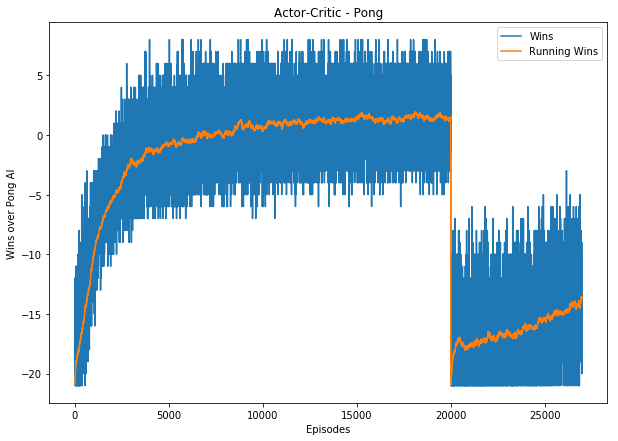

In [34]:
# data = pickle.load(open('./results/actor-critic/pong_ep=20000history.p', 'rb'))
data = actorCritic

# Plot out reward and running reward over training episodes
plt.figure(figsize=(10, 7))

plt.plot(list(range(1,len(np.array(data)[:,0])+1)), np.array(data)[:,0], label='Wins')
plt.plot(list(range(1,len(np.array(data)[:,1])+1)), np.array(data)[:,1], label='Running Wins')
plt.title('Actor-Critic - Pong')
plt.xlabel('Episodes')
plt.ylabel('Wins over Pong AI')
plt.legend()
plt.show()

In [35]:
gc.collect()  # clean up some garbage
torch.cuda.empty_cache()  # Release GPU memory

## Load Parameters and Let's Play

The code below loads parameters from saved model into the actor-critic agent and renders 1 episode. The agent and the game will play til one of them reach 21 points.

In [ ]:
import argparse
import gym
import numpy as np
from itertools import count
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.distributions import Categorical

gamma=0.99
verbose=False  # To step through the code and understand what is going on

# The function approximators for the Actor and the Critic is a 2-layer NN with 2 heads
# - The NN takes in the state of Pong, which is a resampled 40x40 image
# - there are 200 hidden units in the NN
# - The action_head (Actor) computes softmax output for actions (L and R) 
# - The value_head (Critic) computes an estimate for the value function Q_w(s, a)
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(1600, 200)
        self.action_head = nn.Linear(200, 2)
        self.value_head = nn.Linear(200, 1)  

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.affine1(x))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values

def process_frame40(frame):
    """ 
    prepro 210x160x3 uint8 frame into 1600 (40x40) 1D float vector 
    """
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame


def select_action(state):
    """ 
    Use Policy to select an action based on state returned by Pong. The output expected by the PONG 
    is:
    ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
    
    So we need to return 2 (UP/RIGHT) and 3(DOWN/LEFT)
    """

    state = torch.from_numpy(state).float()
    # Use Policy to generate probability for actions and value function
    probs, state_value = model(Variable(state.type(gpu_dtype), requires_grad=False))

    # Sample action stochastically    
    m = Categorical(probs)
    action = m.sample()
    
    # Store log_prob (score function) and value function into a list to update Actor and Critic 
    # parameters later on
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    
    return action.data[0]+2  # UP=2, DOWN=3

# Call an instance of the Policy and load it with a parameter file
model = Policy().cuda()
# file_name='./results/actor-critic/pong_ep=18000model.pt'
file_name='./results/actor-critic/pong_ep=6000model.pt'
model.load_state_dict(torch.load(file_name))
model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

env = gym.make("Pong-v0")
state = env.reset()
prev_x = None # used in computing the difference frame

reward_sum = 0

t = 0

while t < 10000:  # make sure there is no infinite loop
  t += 1
  env.render()
    
  time.sleep(0.01)  # slow it down for us to observe

  # preprocess the observation, set input to network to be difference image
  cur_x = process_frame40(state)
  state = cur_x - prev_x if prev_x is not None else np.zeros(1600)
  prev_x = cur_x

  # Sample an action from Policy based on state provided by env
  action = select_action(state)
        
  # step env through the sampled action
  state, reward, done, _ = env.step(action)
  reward_sum += reward
        
  if done: # an episode finished
    gc.collect()  # clean up some garbage
    torch.cuda.empty_cache()  # Release GPU memory
    break

env.close()
print (reward_sum)

## Downsampling

We discover that if we downsample the Pong image to 40x40 using preprop, the pong ball can be sampled out.

We utilize a more sophisticated processing technique from GitHub using cv2

https://github.com/ikostrikov/pytorch-a3c/blob/master/envs.py

(210, 160, 3)
[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.25751635  0.25751635  0.25751635 ...,  0.25751635  0.25751635
  0.25751635]


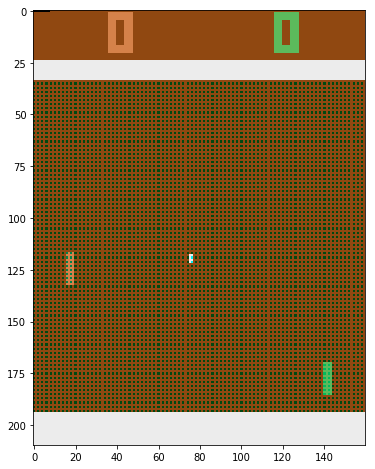

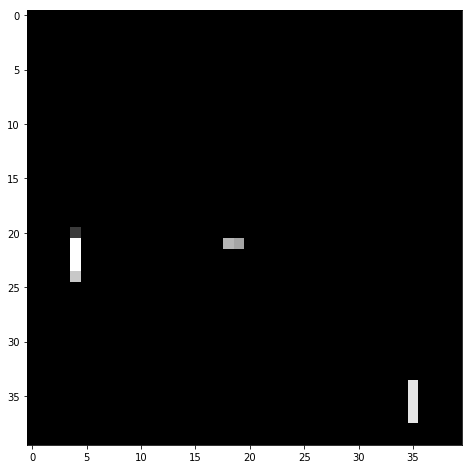

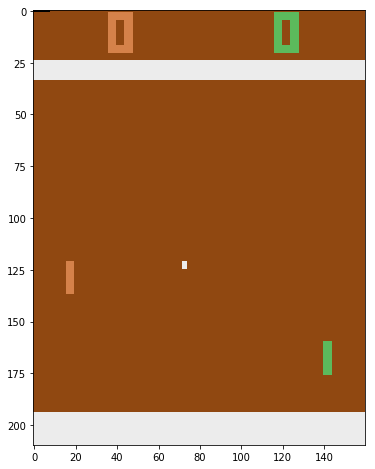

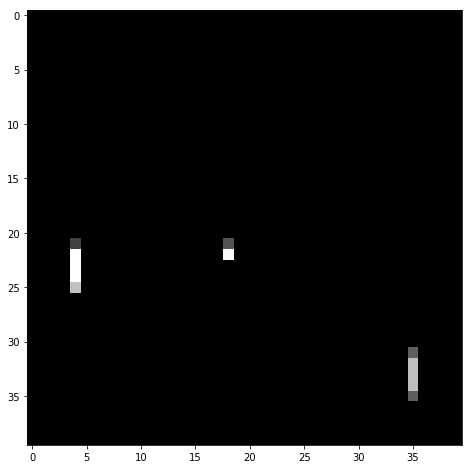

In [39]:
def prepro(I):
    """ 
    prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector 
    """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

def process_frame42(frame):
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (40, 40))
    frame = frame.mean(2)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.reshape(frame, [-1])
    return frame

env = gym.make("Pong-v0")
state = env.reset()
print (state.shape)

for i in range(20):
    action = random.randint(2,3)
    state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

cur_x_1 = prepro(state)
cur_x = process_frame42(state)

print (cur_x_1)
print (cur_x)

plt.figure()
plt.imshow(state) 
plt.show()  # display it

plt.figure()
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it

state, reward, done, _ = env.step(action)  # UP=2, DOWN=3

cur_x = process_frame42(state)

plt.figure()
plt.imshow(state) 
plt.show()  # display it

plt.figure()
plt.imshow(cur_x.reshape(40,40)) 
plt.show()  # display it